### 110062539 chKoogoo

In [1]:
#INPUT_SHAPE = (224, 224, 3)
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 99 # 如果過多少個EPOCHS沒改善就停止訓練
CATGORICAL = 10
LR = 0.001
LR_FACTOR = 0.5 # new_lr = lr * factor.
LR_PATIENCE = 8 # umber of epochs with no improvement after which learning rate will be reduced
MODEL_NAME = 'cifar10_Densenet121_current'
MODEL_PATH = MODEL_NAME + '.hdf5'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        # set memory limit
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024)])

       
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1Metal device set to: Apple M1
 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized


2022-01-17 05:04:51.242198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-17 05:04:51.242591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Start Try5: Data augmentation:

https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.FancyPCA

https://hackmd.io/@allen108108/SyCsOIkxB

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/zh/preprocessing/image/

http://www.tisv.cn/14/

- 單純flip, rotate沒什麼用，像是pixelwise的operation效果顯著（試驗第一個連結的所有function）

- 之後把有用的function全部放在一起訓練

In [4]:
x_train = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/x_train_cifar10_unlearn.npy')
y_train = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/y_train_cifar10.npy')
x_val = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/x_val_cifar10.npy')
y_val = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/y_val_cifar10.npy')
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# ohe labels
y_train = tf.one_hot(y_train, 10)
y_val = tf.one_hot(y_val, 10)

In [5]:
checkpoint = ModelCheckpoint(filepath=MODEL_PATH, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=LR_FACTOR, 
                                   patience=LR_PATIENCE, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=1.25e-4)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=PATIENCE)

callbacks_list = [checkpoint, reduceLROnPlat, early]
#callbacks_list = [checkpoint, reduceLROnPlat]

## Model: Densenet121

In [6]:
''' try2: Densenet121 '''
model = Sequential([
#    data_augmentation,
    tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=max,
    classes=10
),
#     layers.Conv2D(2048, (1, 1), activation="relu"),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax'),
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "cifar10_Densenet121_current"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 10)                7047754   
                                                                 
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_________________________________________________________________


In [7]:
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=False) ##
optimizer = tf.optimizers.Adam(learning_rate=LR)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## Transformer function

In [8]:
import albumentations as A
import cv2

In [9]:
''' define types of transformer of images '''

transformer_try = A.Compose([   
#    A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
#    A.Downscale (scale_min=0.1, scale_max=0.9, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1),
#    A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1),
#    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
#    A.Posterize (num_bits=4, always_apply=False, p=1) #不能用
#    A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
#    A.Equalize (mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1) #不能用
#    A.ChannelShuffle(p=1.0)
#    A.GridDistortion (num_steps=3, interpolation=cv2.INTER_NEAREST, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
#    A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=1.0) #不能用
#    A.HorizontalFlip(p=1.0)
#    A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
#    A.ToGray(p=1.0),
#    A.Sharpen (alpha=(0.3, 0.5), lightness=(0.8, 1.0), always_apply=False, p=1.0)
#    A.ToSepia (always_apply=False, p=1.0)
    A.Superpixels (p_replace=0.1, n_segments=100, max_size=32, interpolation=1, always_apply=False, p=1.0)
    
    
],  p=1)


transformer1 = A.Compose([   
    A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), val_shift_limit=(-40./255, -40./255), always_apply=False, p=1)
],  p=1)

transformer7 = A.Compose([   
    A.ChannelShuffle(p=1.0)
],  p=1)

transformer11 = A.Compose([   
    A.ToGray(p=1.0)
],  p=1)

transformer12 = A.Compose([   
    A.ToSepia (always_apply=False, p=1.0)
],  p=1)

transformer5 = A.Compose([   
    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
],  p=1)



transformer = A.Compose([   
    #A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1),
    #A.JpegCompression (quality_lower=99, quality_upper=100, always_apply=False, p=1),
    A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), val_shift_limit=(-40./255, -40./255), always_apply=False, p=1),
#    A.FancyPCA (alpha=0.1, always_apply=False, p=0.5)
],  p=1)




transformer_a = A.Compose([   
    #A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1),
    #A.JpegCompression (quality_lower=99, quality_upper=100, always_apply=False, p=1),
    A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), val_shift_limit=(-40./255, -40./255), always_apply=False, p=1),
#    A.FancyPCA (alpha=0.1, always_apply=False, p=0.5)
],  p=1)

transformer_b = A.Compose([   
    #A.HorizontalFlip(p=1),
#    A.GaussianBlur (blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=1)
    A.Affine(p=1),
    A.GaussNoise(var_limit=(1.0/255., 10.0/255.), mean=np.mean(x_train[0], axis=(0, 1, 2)), p=1),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
    #A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
],  p=1)

transformer_c = A.Compose([   
    A.HorizontalFlip(p=1),
    A.GaussNoise(var_limit=(1.0/255., 10.0/255.), mean=np.mean(x_train, axis=(0, 1, 2)), p=1),
#    A.MotionBlur(blur_limit=17, p=1)
#    A.RGBShift(p=1),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
],  p=1)



image_size_aug = 36
image_size = 32
pad_size = int((image_size_aug-image_size)/2)

transformer4 = A.Compose([   
    #A.ChannelShuffle(p=0.5),
    #RandomContrast (limit=0.5, always_apply=False, p=1),
    #A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1),
    #A.HorizontalFlip(p=1),
    #A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=1)
    A.CropAndPad (px=pad_size, percent=None, pad_mode=0, pad_cval=0, pad_cval_mask=0, 
                keep_size=True, sample_independently=True, interpolation=cv2.INTER_AREA, always_apply=False, p=1.0),
    A.CropAndPad (px=-pad_size, percent=None, pad_mode=0, pad_cval=0, pad_cval_mask=0, 
                keep_size=True, sample_independently=True, interpolation=cv2.INTER_AREA, always_apply=False, p=1.0)
],  p=1)



/opt/homebrew/Caskroom/miniforge/base/envs/tf_dl/lib/python3.9/site-packages/albumentations/augmentations/functional.py:1753: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = skimage.segmentation.slic(image, n_segments=n_segments, compactness=10)


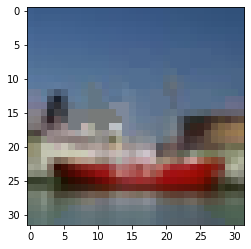

In [10]:
# plot transformer_try
plt.imshow(transformer_try(image = x_train[0])['image'])

In [11]:
def transformed_ds_try(img_ds):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer_try(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

## Create transformed training data & Concatenate those data

In [12]:
def transformed_ds(img_ds, transformer):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

In [13]:
def create_transformed_data(x_train, y_train, transformer_list, num_data_apply_list):
    x_trans_list = []
    y_trans_list = []
    
    for i in range(len(transformer_list)):
        x_trans_list.append(transformed_ds(x_train, transformer_list[i])[ : num_data_apply_list[i]])
        y_trans_list.append(y_train[ : num_data_apply_list[i]])
        
#     for transformer in transformer_list:
#         x_trans.append(transformed_ds(x_train, transformer))
#         y_trans = np.concatenate((y_train , y_train))
    
    return np.array(np.concatenate(x_trans_list)), np.array(np.concatenate(y_trans_list))

In [14]:
transformer_list = [transformer1, transformer7, transformer7, transformer11, transformer12, transformer5]
num_data_apply_list = [len(x_train), len(x_train), len(x_train)//2, len(x_train), len(x_train), len(x_train)//2]


x_train_trans, y_train_trans = create_transformed_data(x_train, y_train, transformer_list, num_data_apply_list)

In [15]:
print(x_train_trans.shape)

(200000, 32, 32, 3)


In [16]:
def transformed_ds1(img_ds):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer1(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

In [17]:
#print(transformed_ds1(x_train).shape)

In [18]:
# # check the result:

# x_train_trans4 = transformed_ds4(x_train)
# x_train_trans3 = transformed_ds3(x_train)
# #print(type(x_train_trans))
# print(x_train_trans4.shape)
# print(x_train.shape)

In [19]:
# # try

# x_train_trans_try = transformed_ds_try(x_train)
# x_train_trans = x_train_trans_try

In [20]:
# x_train_trans = np.concatenate((x_train_trans4 , x_train3))
# y_train = np.concatenate((y_train , y_train))

In [21]:
# model.load_weights(MODEL_PATH)

In [22]:
print(MODEL_PATH)

cifar10_Densenet121_current.hdf5


In [23]:
# with open('ChannelShuffle_data.npy', 'wb') as f:
#     np.save(f, x_train_trans)

## Start Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,  
                                             samplewise_center=False, 
                                             featurewise_std_normalization=False, 
                                             samplewise_std_normalization=False, 
                                             zca_whitening=False, ## val只有0.1
                                             zca_epsilon=1e-06, 
                                             rotation_range=0.0, 
                                             width_shift_range=0.0, ## 0.2
                                             height_shift_range=0.0, ## 0.1
                                             brightness_range=None, ## 不要用，很爛
                                             shear_range=0.0, 
                                             zoom_range=0.0, 
                                             channel_shift_range=0.0, 
                                             fill_mode='nearest', 
                                             cval=0.0, 
                                             horizontal_flip=False, 
                                             vertical_flip=False, ## 不要用，非常糟
                                             rescale=None, 
                                             preprocessing_function=None, 
                                             data_format=None, 
                                             validation_split=0.0, 
                                             dtype=None)

# datagen = ImageDataGenerator(
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train_trans, augment=True, rounds=2, seed=None)

# fits the model on batches with real-time data augmentation:
show_augmented_result_dir = './ImageDataGenerator_result'

history = model.fit(datagen.flow(x_train_trans, y_train_trans, batch_size=BATCH_SIZE, shuffle=True), 
                              steps_per_epoch=len(x_train_trans)/BATCH_SIZE, epochs=EPOCHS,
                              validation_data=(x_val, y_val),validation_steps=len(x_val)/BATCH_SIZE,
                              callbacks=callbacks_list)

''' baseline of x_train: 0.5/0.27[1] ~ 0.94/0.33[4] '''
'''
0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X

1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), 
val_shift_limit=(-40./255, -40./255), always_apply=False, p=1)
: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]

2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]

3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)
: 0.47/0.24[1] -> 0.94/0.18[4]

4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)
: 0.49/0.23 -> 0.95/0.25[4]

5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
: 0.41/0.27[1] -> 0.89/0.46[6]

6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
: 0.49/0.26[1] -> 0.93/0.26[4]

7. (超棒！)A.ChannelShuffle(p=1.0)
: 0.38/0.24[1] -> 0.84/0.59[8] -> 1.0/0.72[50?]
(有把training data存下來了('channelShuffle_data.npy')，因為怕是random channelShuffle剛好有不錯的結果)(QQ被我自己洗掉了)

8.（普通）A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
: 0.44/0.25[1] -> 0.92/0.37[6] -> 0.95/0.32[10]

9. (沒用)HorizontalFlip(p=0.1)
: 0.50/0.27[1] -> 0.92/0.29[3]
實驗證明，flip在這個task根本沒有幫助

10.（普通）A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
: 0.9/0.37[6]
跟shift的value有關

11. (不錯呦！)A.ToGray(p=1.0)
: 0.39/0.29[1] -> 0.86/0.55[8]

12. (不錯呦！)A.ToSepia (always_apply=False, p=1.0)
: 0.39/0.18[1] -> 0.79/0.52[6] -> 0.96/0.57[11]
train epochs要多點, lr小點，太大會overshoot

13. (bad)A.Superpixels (p_replace=0.1, n_segments=100, max_size=32, interpolation=1, always_apply=False, p=1.0)
: 0.53/0.21[1] -> 0.97/0.29[9]

# combined result:

((1, 7, 7, 11, 12), (5)), data量(1: 1: 0.5: 1: 1: 0.5)
: 


'''

2022-01-17 05:05:47.137121: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-01-17 05:05:49.893018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 318/3125 [==>...........................] - ETA: 7:00 - loss: 1.9311 - acc: 0.3056

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./output_training_plot/densenet121_try5_current', dpi='figure')
plt.show()

## Testing data output

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
x_test = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/x_test_cifar10.npy')

In [ ]:
y_test = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE, verbose=1), axis=1).tolist()

In [ ]:
id_csv = [i for i in range(len(y_test))]
df = pd.DataFrame(list(zip(id_csv,y_test)), columns = ['id','label'])
df.to_csv('./output_csv/cifar10_try5_densenet121_current.csv', index=False)

#### 